In [40]:
import pandas as pd 
import numpy as np 
import evoVAE.utils.metrics as mt 
import evoVAE.utils.seq_tools as st
from numba import njit, prange, jit
import random
#pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [53]:
indices = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/sanjana_clustering_data/gb1_indices/gb1_0.22_replicates_sanjana.csv")
indices

,rep_3,rep_2,rep_4,rep_5,rep_1
0,6,0,1,6,3
1,12,21,3,13,9
2,16,22,6,20,21
3,20,23,7,21,22
4,21,24,9,22,23
...,...,...,...,...,...
6995,46202,46202,46202,46202,46202
6996,46205,46205,46205,46205,46205
6997,46208,46208,46208,46208,46208
6998,46229,46229,46229,46229,46229


In [69]:
df = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/gb1_ancestors_extants_no_dupes.pkl")
df = df.loc[indices["rep_5"]]
print(df.shape)
df[~df["id"].str.contains("tree")]

(7000, 2)


,id,sequence
43148,SPG1_STRSG/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
43149,UniRef100_Q93EM8/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...
43150,UniRef100_Q53975/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...
43152,UniRef100_A0A448DI38/1-351,MEKEKKMKYFLRKSAFGLASVSAAFLVGTTLDTTMTVSAEPAGIIA...
43158,UniRef100_UPI0013FD4572/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
...,...,...
46202,UniRef100_UPI000768A238/12-386,----------------------ASVALGAGVASQPTVVRAEEA---...
46205,UniRef100_UPI001959AF38/4-600,-------KFSIRKLAVGVVSVSIGITGLSTISTDNITFANTHTVS-...
46208,UniRef100_UPI000765255D/5-423,-KSERKVHYSIRKFSIGVASVVVASLFLGGVVHAEGVRSKNNLTVT...
46229,UniRef100_UPI001454C06F/5-327,-KSERKVHYSIRKFSIGVASVVVASLVMGSVVHATEKEGITPVATS...


,id,sequence
43148,SPG1_STRSG/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
43149,UniRef100_Q93EM8/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...
43150,UniRef100_Q53975/1-351,MEKEKKVKYFLRKSAFGLASVSAAFLVSGALENTITVSAE--TIPA...
43152,UniRef100_A0A448DI38/1-351,MEKEKKMKYFLRKSAFGLASVSAAFLVGTTLDTTMTVSAEPAGIIA...
43158,UniRef100_UPI0013FD4572/1-448,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
...,...,...
46202,UniRef100_UPI000768A238/12-386,----------------------ASVALGAGVASQPTVVRAEEA---...
46205,UniRef100_UPI001959AF38/4-600,-------KFSIRKLAVGVVSVSIGITGLSTISTDNITFANTHTVS-...
46208,UniRef100_UPI000765255D/5-423,-KSERKVHYSIRKFSIGVASVVVASLFLGGVVHAEGVRSKNNLTVT...
46229,UniRef100_UPI001454C06F/5-327,-KSERKVHYSIRKFSIGVASVVVASLVMGSVVHATEKEGITPVATS...


In [65]:
1540/7000

0.22

In [11]:
df = pd.read_csv("/Users/sebs_mac/Downloads/DMS_ProteinGym_indels/A4_HUMAN_Seuma_2022_indels.csv")

In [20]:
wt = "MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQITNVVEANQPVTIQNWCKRGRKQCKTHPHFVIPYRCLVGEFVSDALLVPDKCKFLHQERMDVCETHLHWHTVAKETCSEKSTNLHDYGMLLPCGIDKFRGVEFVCCPLAEESDNVDSADAEEDDSDVWWGGADTDYADGSEDKVVEVAEEEEVAEVEEEEADDDEDDEDGDEVEEEAEEPYEEATERTTSIATTTTTTTESVEEVVREVCSEQAETGPCRAMISRWYFDVTEGKCAPFFYGGCGGNRNNFDTEEYCMAVCGSAMSQSLLKTTQEPLARDPVKLPTTAASTPDAVDKYLETPGDENEHAHFQKAKERLEAKHRERMSQVMREWEEAERQAKNLPKADKKAVIQHFQEKVESLEQEAANERQQLVETHMARVEAMLNDRRRLALENYITALQAVPPRPRHVFNMLKKYVRAEQKDRQHTLKHFEHVRMVDPKKAAQIRSQVMTHLRVIYERMNQSLSLLYNVPAVAEEIQDEVDELLQKEQNYSDDVLANMISEPRISYGNDALMPSLTETKTTVELLPVNGEFSLDDLQPWHSFGADSVPANTENEVEPVDARPAADRGLTTRPGSGLTNIKTEEISEVKMDAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIATVIVITLVMLKKKQYTSIHHGVVEVDAAVTPEERHLSKMQQNGYENPTYKFFEQMQN"
len(wt)

770

In [24]:
for actual, var in zip(wt, df["mutated_sequence"][0]):
    print(len(wt))
    print(len(df["mutated_sequence"][0]))
    print(actual, var)
    break

770
731
M M


In [22]:
print(len(df["mutated_sequence"][0]))

731


In [103]:
PATH = "/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv"

def split_by_mutations(dms_data):
    """
    Create a subset of the mutation DataFrames based on how many mutations
    are in the variant.

    Return:
    A dictionary mapping mutation count to subset dataframe
    """

    # define a function for counting mutations
    splitter = lambda x: len(x.split(":"))
    dms_data["mut_count"] = dms_data["mutant"].apply(splitter)

    subframes = dict()
    for count in dms_data["mut_count"].unique():
        subframes[count] = dms_data.loc[dms_data["mut_count"] == count]

    return subframes

dms = pd.read_csv(PATH)
dms.head()

subframe = split_by_mutations(dms)
subframe[2].shape

(14015, 5)

In [104]:
#aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants_no_dupes.fasta", encode=False)
aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_no_dupes.fasta", encode=False)
#aln.drop(columns=["encoding"], inplace=True)
#aln.head()
aln.to_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_no_dupes.pkl")

Reading the alignment: /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_no_dupes.fasta
Checking for bad characters: ['B', 'J', 'X', 'Z', 'U']
Number of seqs: 4936


In [ ]:
aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.pkl")
aln.head()

In [41]:

def process_file_path(file_path):
    groups = [x for x in os.listdir(file_path) if x != ".DS_Store"]
    dirs = [file_path + x + "/" for x in os.listdir(file_path) if x != ".DS_Store"]

    return groups, dirs


def plot_clustering_loss(file_path, figure_name, rows, columns, max_reps: int = 10):

    groups, dirs = process_file_path(file_path)

    # Prepare the figure
    fig, axes = plt.subplots(rows, columns, figsize=(4, 2))  # 2 rows, 5 columns

    # Loop through groups and images
    # Two rows
    for col in range(columns):  # Five columns
        sampled = []
        for row in range(1, rows + 1):

            # to_show = random.randint(1, max_reps)
            # while to_show in sampled:
            #     to_show = random.randint(1, max_reps)
            
            # sampled.append(to_show)
            
            image_path = dirs[col] + f"{groups[col]}_extants_r{row}/loss.png"
            
            # Load and display the image
            img = Image.open(image_path)
            axes[row - 1, col].imshow(img)
            axes[row - 1, col].axis('off')

    # Adjust layout
    # Reduce vertical space between subplots
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust vertical space between subplots (default is 0.2)
    plt.savefig(figure_name, dpi=800, bbox_inches='tight')
    plt.show()

def plot_standard_loss(file_path, figure_name, rows = 3, columns = 3, max_reps: int = 15):

    groups, dirs = process_file_path(file_path)

    # Prepare the figure
    fig, axes = plt.subplots(rows, columns, figsize=(4, 2)) 

    # Loop through groups and images
    # Two rows
    for col in range(columns):  # Five columns
        sampled = []
        for row in range(1, rows + 1):

            # to_show = random.randint(1, max_reps)
            # while to_show in sampled:
            #     to_show = random.randint(1, max_reps)
            
            #sampled.append(to_show)
            
            image_path = dirs[col] + f"{groups[col]}_r{row}/loss.png"
            
            # Load and display the image
            img = Image.open(image_path)
            axes[row - 1, col].imshow(img)
            axes[row - 1, col].axis('off')

    # Adjust layout
    # Reduce vertical space between subplots
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust vertical space between subplots (default is 0.2)
    plt.savefig(figure_name, dpi=800, bbox_inches='tight')
    plt.show()

def combine_standard_replicates(file_path, max_reps: int = 15):
    
    groups, dirs = process_file_path(file_path)

    df_list = []
    for r in range(1, max_reps + 1):
        for g, group in enumerate(groups):
            file = dirs[g] + f"{groups[g]}_r{r}/zero_shot_all_variants_final_metrics.csv"
            df_list.append(pd.read_csv(file))

    # #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
    results = pd.concat(df_list, ignore_index=True)

    print(results.shape)
    return results

def combine_clustering_replicates(file_path, max_reps: int = 15):

    groups, dirs = process_file_path(file_path)

    df_list = []
    for r in range(1, max_reps + 1):
        for g, group in enumerate(groups):
            file = f"{file_path + groups[g]}/{groups[g]}_extants_r{r}/zero_shot_all_variants_final_metrics.csv"
            df_list.append(pd.read_csv(file))

    # #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
    cluster_results = pd.concat(df_list, ignore_index=True)
    print(cluster_results.shape)

    return cluster_results

def get_standard_label(lab):
        data = lab.split("/")[1].split("_")
        if len(data) == 3:
            # anc or extant
            return data[1]
        else:
            return "_".join(data[1:-1])
        

def plot_standard_metrics(std_results, protein_name):

    # use unique id to work out which sample it is 
    # get which replicate it is 
    get_rep = lambda x: int(x.split("/")[1].split("_")[-1][1:])
    # get extants, ancestor or anc_extant label in sample
   

    rep = std_results["unique_id"].apply(get_rep)

    ext_prop = std_results["unique_id"].apply(get_standard_label)

    std_results["replicate"] = rep
    std_results["sample"] = ext_prop

    labels = std_results["sample"].unique()
    labels.sort()
    
    points = [std_results.loc[std_results["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc", "pearson"]
    for m in metrics:

        
        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Extant sample proportion')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Average parwise covariance Pearson\'s correlation')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()

    

def plot_clustering_metrics(cluster_results, protein_name):

    # get which replicate it is 
    get_rep = lambda x: int(x.split("/")[1].split("_")[-1][1:])
    # get proportion of extants in sample
    get_ex = lambda x: float(x.split("/")[1].split("_")[1]) 


    rep = cluster_results["unique_id"].apply(get_rep)

    ext_prop = cluster_results["unique_id"].apply(get_ex)

    cluster_results["replicate"] = rep
    cluster_results["sample"] = ext_prop

    labels = cluster_results["sample"].unique()
    labels.sort()
    
    points = [cluster_results.loc[cluster_results["sample"] == prop] for prop in labels]

    metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc", "pearson"]
    for m in metrics:

        
        means = [point[m].mean() for point in points]
        std_devs = [point[m].std() for point in points] 

        x_pos = np.arange(len(labels))

        fig, ax = plt.subplots()

        # Create bars
        bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

        for i, point in enumerate(points):
            ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


        # Add labels
        ax.set_xlabel('Extant sample proportion')
        ax.set_ylabel(f'Mean {m}')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(labels)

        #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
        if m == "pearson":
            ax.set_title(f'{protein_name}: Average parwise covariance Pearson\'s correlation')
        else: 
            ax.set_title(f'{protein_name}: Average {m}')


        # Add a grid for better readability
        ax.yaxis.grid(True)

        # Save the figure and show
        plt.tight_layout()
        plt.show()



# GB1 clustering 

#### Creating replicates

1. Take output from mmSeqs which has clusters 
2. Separate into representative clusters 
3. Sample without replcement to make sample sizes of 10,000

In [ ]:
# this is the dataframe where all sampling will take place from, indices that are sampled will refer to this dataset
aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/encoded_weighted/gb1_ancestors_extants_encoded_weighted_no_dupes.pkl")
aln = aln.drop_duplicates(subset=['sequence'])
#aln = aln.sample(frac=0.2)
print(aln.shape)
aln.head()

# get into numeric form for quicker processing 
msa, seq_key, key_label = st.convert_msa_numpy_array(aln)
msa.shape

In [ ]:

# read the mmSeqs clustering output 
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/mmseqs_clustering/gb1_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape


In [ ]:
results.loc[results["is_ancestor"] == 0].shape

In [ ]:
# actual sampling and then write this to one csv per protein family 

SAMPLE_SIZE = 10000
extant_proportions = [0.15, 0.10, 0.05, 0.0]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/gb1_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices

    test.to_csv(f"gb1_{p}_replicates.csv", index=False)
#st.write_fasta_file(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

#### GB1 clustering results - loss

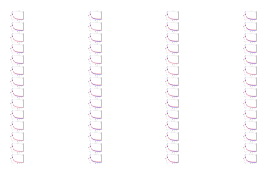

In [42]:
gb1_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gb1_seb_clusters/"
figure_name = "gb1_cluster_loss.png"

plot_clustering_loss(gb1_file_path, figure_name, columns=4, rows=14)

#### GB1 clustering results - metrics: 14 replicates

In [43]:
gb1_all_cluster_results = combine_clustering_replicates(gb1_file_path, max_reps=14)
gb1_all_cluster_results.head()
gb1_all_cluster_results.head()

(56, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gb1_0.0_extants_r1/,0.036463,0.196706,0.106826,0.611126,0.849703
1,./gb1_0.1_extants_r1/,0.018042,0.179432,0.074598,0.591279,0.860188
2,./gb1_0.05_extants_r1/,0.020521,0.174612,0.120950,0.587903,0.838026
3,./gb1_0.15_extants_r1/,-0.014783,0.182043,0.078944,0.571031,0.847458
4,./gb1_0.0_extants_r2/,0.016212,0.169523,0.113829,0.592730,0.855009


In [128]:
test = gb1_all_cluster_results[gb1_all_cluster_results["unique_id"].apply(lambda x: x.split("_")[1]) == "0.15"]
np.mean(test["spearman_rho"])

-0.00960028197538875

In [119]:
np.mean(test["spearman_rho"])

0.015667727139325998

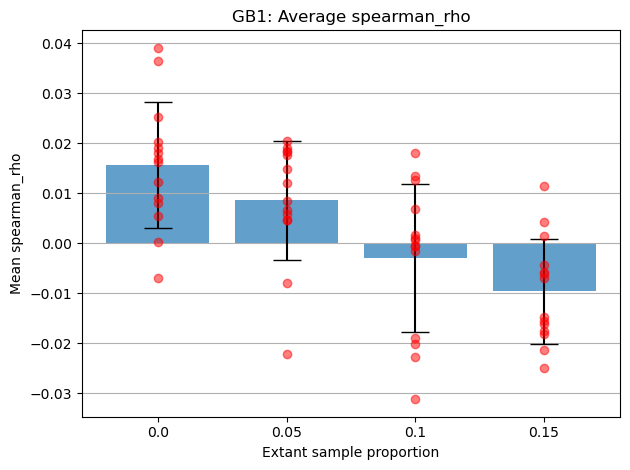

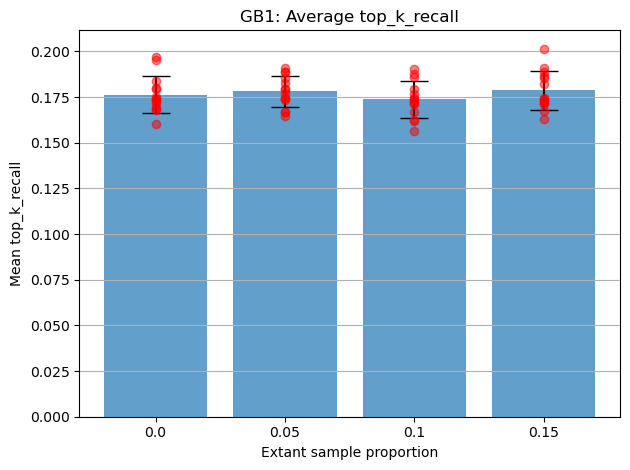

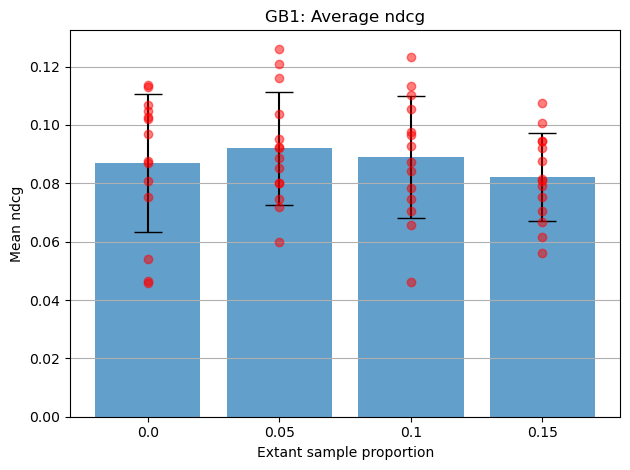

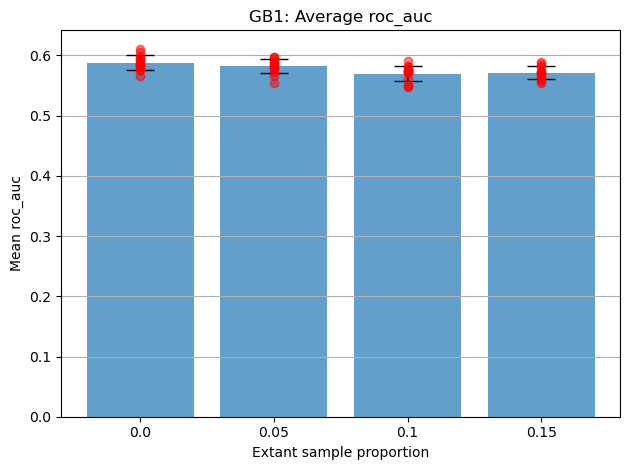

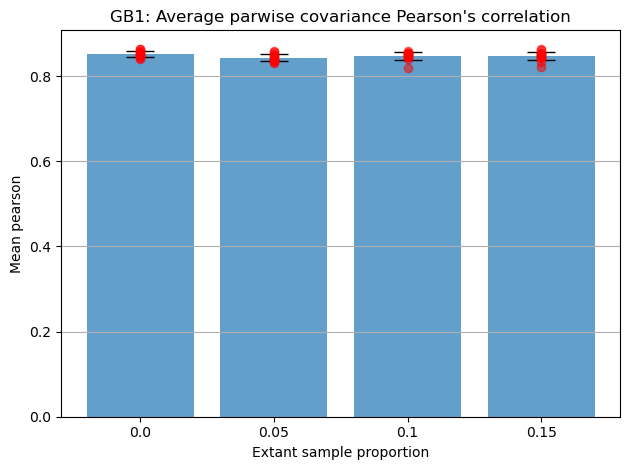

In [44]:
plot_clustering_metrics(gb1_all_cluster_results, "GB1")

#### GB1 Standard - loss

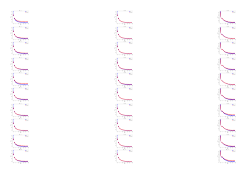

In [45]:
gb1_std_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gb1_standard/"
plot_standard_loss(gb1_std_file_path, "gb1_std_loss.png", columns=3, rows=10)

#### GB1 - standard results - metrics: 14 replicates

In [47]:
# #all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
gb1_all_std_results =combine_standard_replicates(gb1_std_file_path, max_reps=10)
gb1_all_std_results.head()

(30, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gb1_ae_r1/,-0.005853,0.186730,0.084084,0.578094,0.868194
1,./gb1_a_r1/,0.012710,0.176486,0.095541,0.586808,0.859821
2,./gb1_e_r1/,0.035040,0.204205,0.084674,0.615814,0.718238
3,./gb1_ae_r2/,-0.016399,0.180303,0.065375,0.551590,0.865158
4,./gb1_a_r2/,0.024605,0.192086,0.135266,0.595154,0.874347


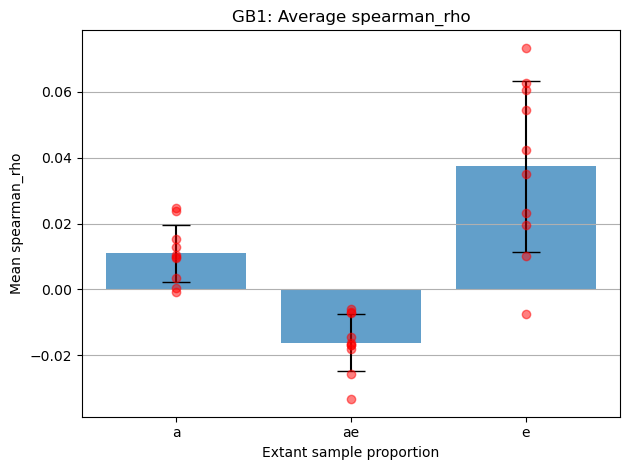

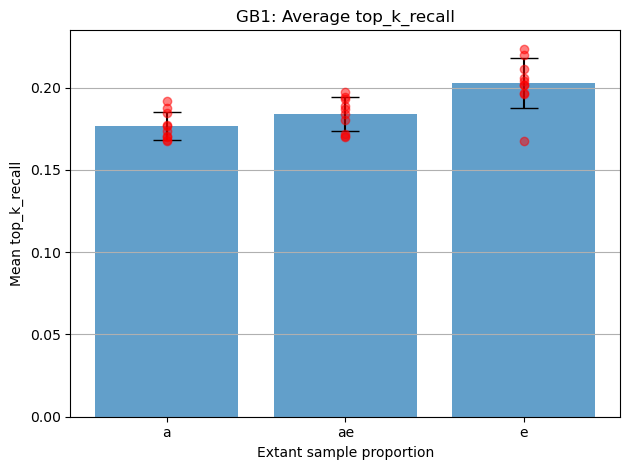

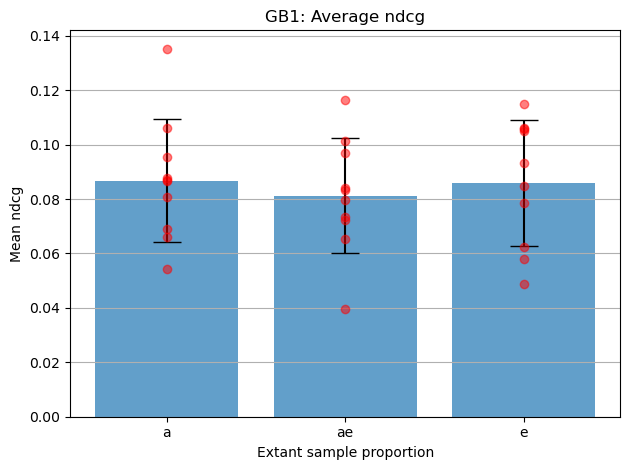

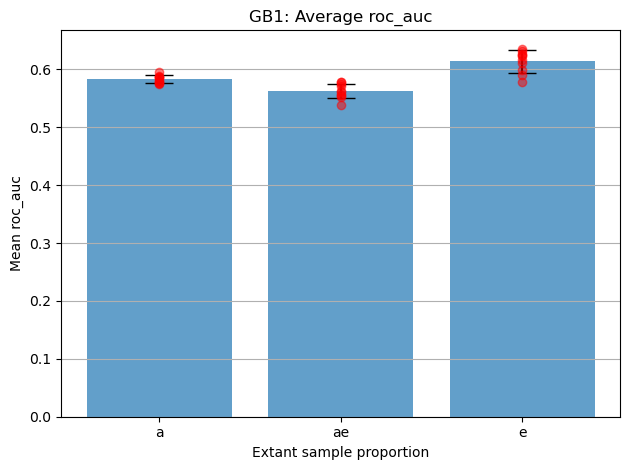

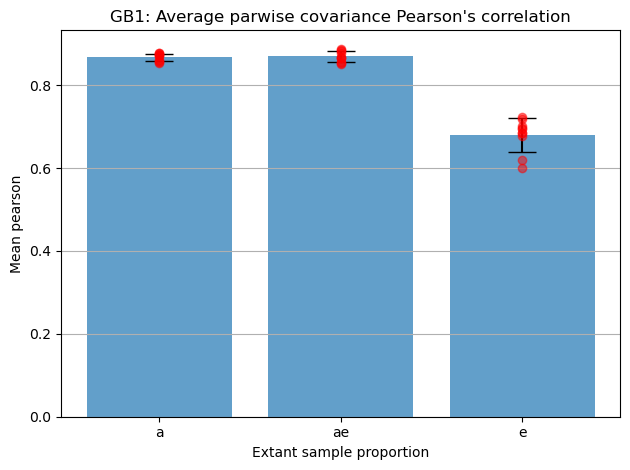

In [48]:
plot_standard_metrics(gb1_all_std_results, "GB1")

# A4 human clustering 

#### Getting cluster replicates

In [ ]:
# this is the dataframe where all sampling will take place from, indices that are sampled will refer to this dataset
a4_aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4/encoded_weighted/a4_ancestors_extants_encoded_weighted_no_dupes.pkl")
#aln = aln.sample(frac=0.2)
print(a4_aln.shape)
a4_aln.head()

# get into numeric form for quicker processing 
a4_msa, seq_key, key_label = st.convert_msa_numpy_array(a4_aln)
a4_msa.shape


In [ ]:
# read the mmSeqs clustering output 
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/a4/mmseqs_clustering/a4_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape

In [ ]:

SAMPLE_SIZE = 10000
extant_proportions = [0.0, 0.05, 0.1, 0.15, 0.2]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4/alns/a4_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices

    test.to_csv(f"a4_{p}_replicates.csv", index=False)
#st.write_fasta_file(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

#### A4 clustering results - loss

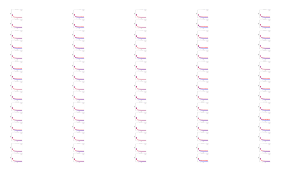

In [49]:
a4_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/a4_seb_clusters/"
figure_name = "a4_cluster_loss.png"

plot_clustering_loss(a4_file_path, figure_name, rows=15, columns=5)

#### A4 clustering results - metrics: 15 replicates

In [50]:
a4_all_cluster_results = combine_clustering_replicates(a4_file_path, max_reps=15)
a4_all_cluster_results.head()

(75, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./a4_0.05_extants_r1/,0.402089,0.169366,0.651605,0.710523,0.951000
1,./a4_0.1_extants_r1/,0.360248,0.142375,0.570118,0.685995,0.969421
2,./a4_0.0_extants_r1/,0.391444,0.163968,0.667046,0.705663,0.973921
3,./a4_0.2_extants_r1/,0.348479,0.147773,0.678819,0.684188,NaN
4,./a4_0.15_extants_r1/,0.361056,0.122807,0.672136,0.690237,0.954990


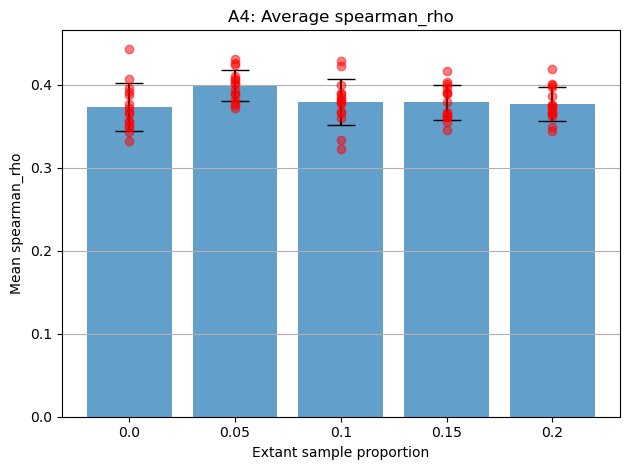

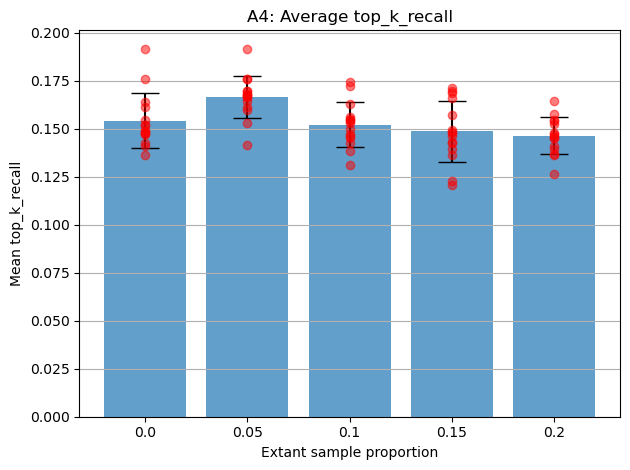

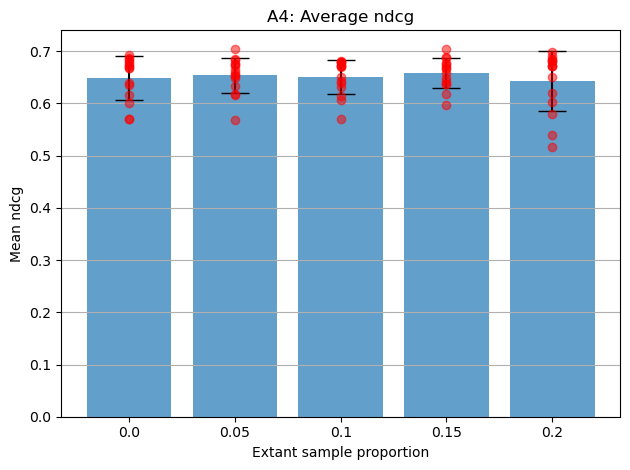

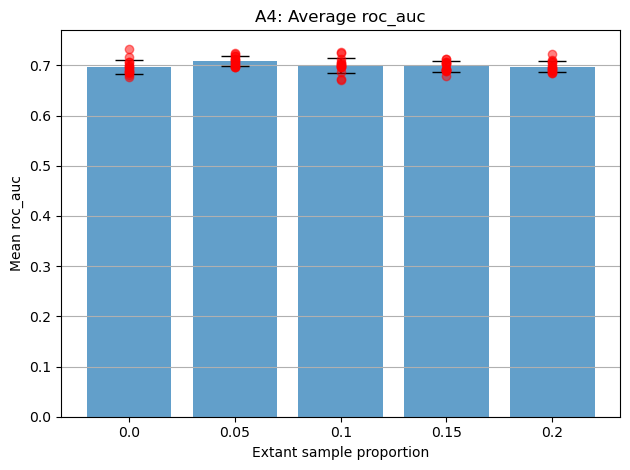

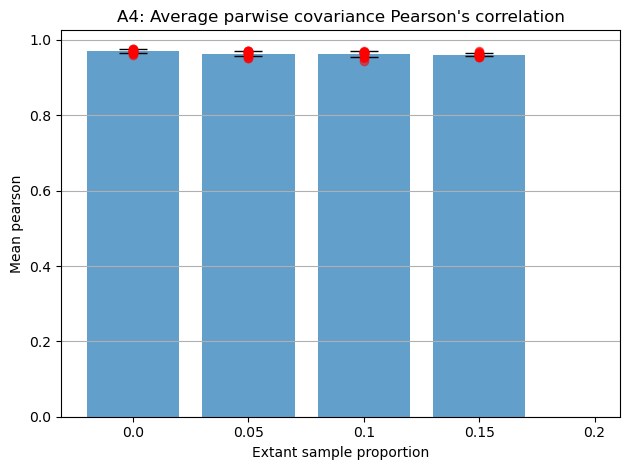

In [51]:
plot_clustering_metrics(a4_all_cluster_results, "A4")

#### A4 Standard results - loss

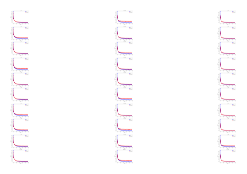

In [52]:
a4_std_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/a4_standard/"
plot_standard_loss(a4_std_file_path, "a4_std_loss.png", columns=3, rows=10)

#### A4 Standard results - metrics: 15 replicates

In [53]:
a4_all_std_results = combine_standard_replicates(a4_std_file_path, max_reps=10)
a4_all_std_results.head()

(30, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./a4_e_r1/,0.389639,0.153846,0.571244,0.703768,0.934355
1,./a4_ae_r1/,0.377631,0.156545,0.633652,0.697574,0.979252
2,./a4_a_r1/,0.408600,0.168691,0.698729,0.713378,0.981339
3,./a4_e_r2/,0.360422,0.152497,0.674650,0.689416,0.953515
4,./a4_ae_r2/,0.401243,0.167341,0.633299,0.705016,0.977381


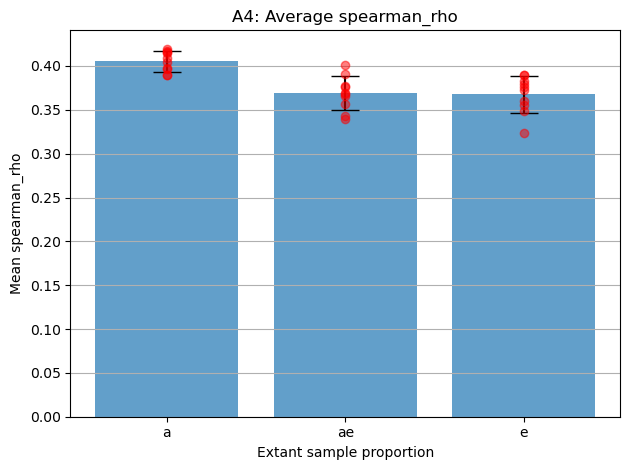

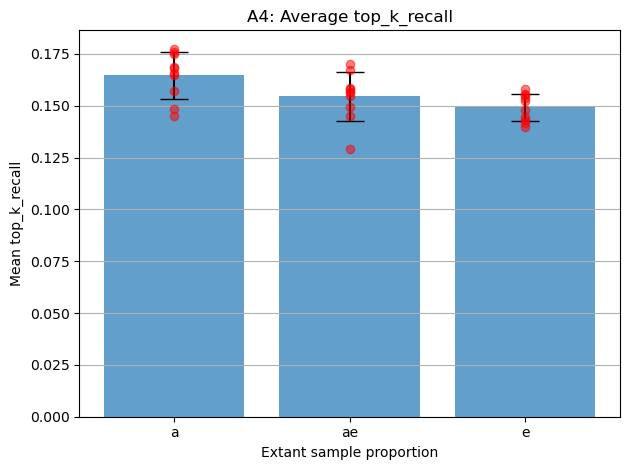

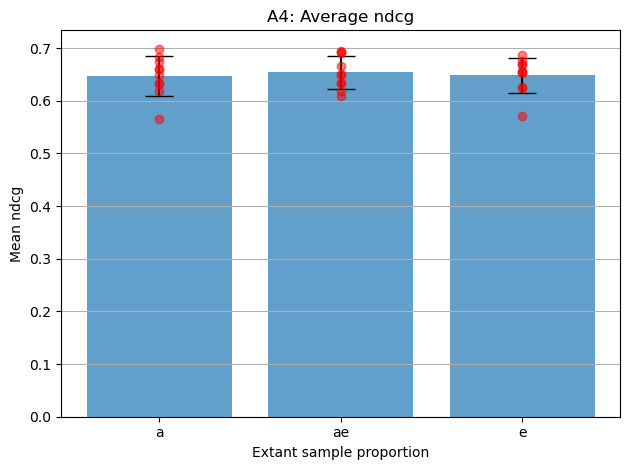

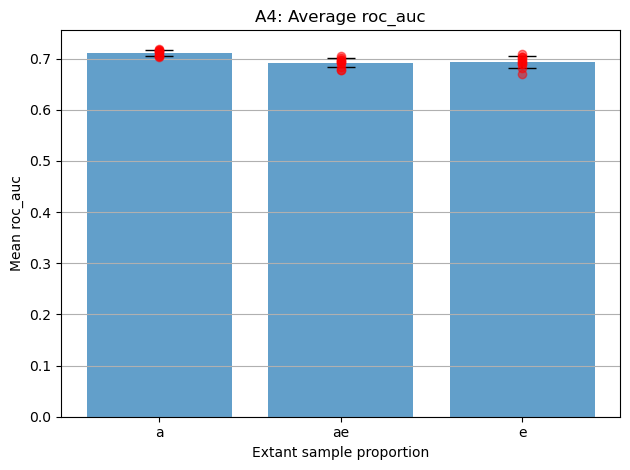

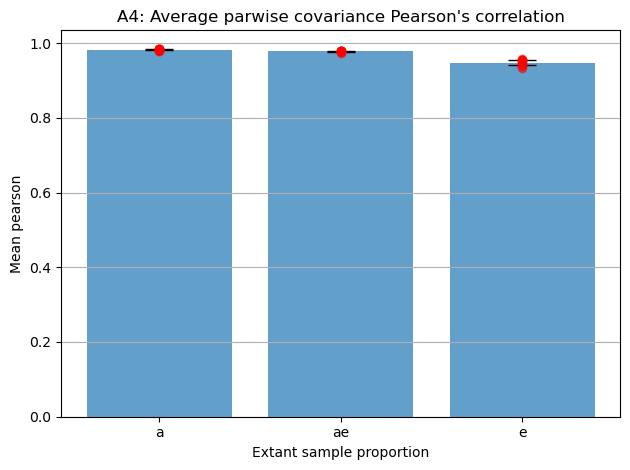

In [54]:
plot_standard_metrics(a4_all_std_results, "A4")

# GCN4 clustering

#### GCN4 - getting cluster replicates

In [139]:
clustering_results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/mmseqs_clustering/gcn4_an_ex_cluster.tsv", sep="\t", header=None)
clustering_results.columns = ["cluster", "sequence"]

mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = clustering_results["sequence"].apply(mark_ancestors)
clustering_results["is_ancestor"] = is_ancestor

representative_ids = clustering_results["cluster"].unique()

clustering_results
# divide the sequences into their clusters
clusters = [clustering_results.loc[clustering_results["cluster"] == rep] for rep in representative_ids]
len(clusters)

76

In [ ]:
import random
import evoVAE.utils.seq_tools as st


SAMPLE_SIZE = 5000
extant_proportions = [0.06, 0.04, 0.02, 0.0]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices


    test.to_csv(f"gcn4_{p}_replicates.csv", index=False)
       


In [ ]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/clustering_data/gcn4/"

#df_list = [pd.read_csv(file + "/_zero_shot.csv") for file in os.listdir(DATA_PATH)]
df_list = [pd.read_csv((DATA_PATH + str(file) + "/_zero_shot.csv")) for file in os.listdir(DATA_PATH) if str(file) != ".DS_Store"]

all_data = pd.read_csv("gcn4_cluster_sampling_results.csv")
all_data.drop(columns=["Unnamed: 0"], inplace=True)

get_rep = lambda x: x.split("_")[1] 
get_ex = lambda x: x.split("_")[11] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

a4_extant_proportions = all_data["extant_prop"].unique()
a4_extant_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in a4_extant_proportions]



#### GCN4 clustering results - loss

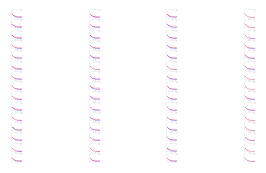

In [61]:
gcn4_file_path =  "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gcn4_seb_clusters/"
figure_name = "gcn4_cluster_loss.png"

plot_clustering_loss(gcn4_file_path, figure_name, rows=15, columns=4)

#### GCN4 clustering results - metrics: 15 replicates

In [62]:
gcn4_all_cluster_results = combine_clustering_replicates(gcn4_file_path, max_reps=15)
gcn4_all_cluster_results.head()

(60, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gcn4_0.02_extants_r1/,0.224013,0.204545,0.467250,0.622018,0.675438
1,./gcn4_0.04_extants_r1/,0.229511,0.223485,0.454045,0.625391,0.745750
2,./gcn4_0.06_extants_r1/,0.238371,0.208333,0.463744,0.629683,0.736565
3,./gcn4_0.0_extants_r1/,0.205115,0.200758,0.451658,0.613473,0.713669
4,./gcn4_0.02_extants_r2/,0.228978,0.223485,0.455006,0.625558,0.704774


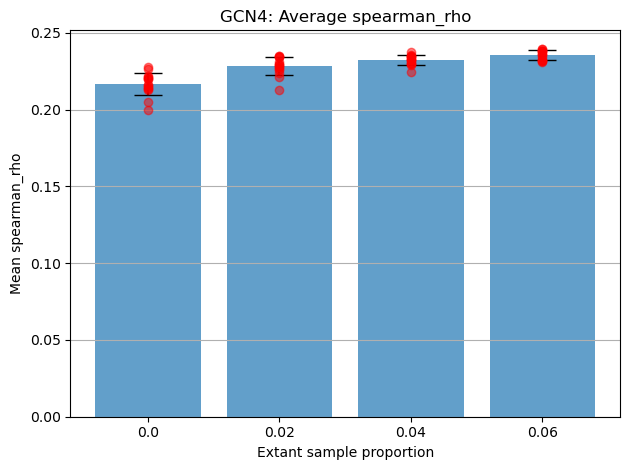

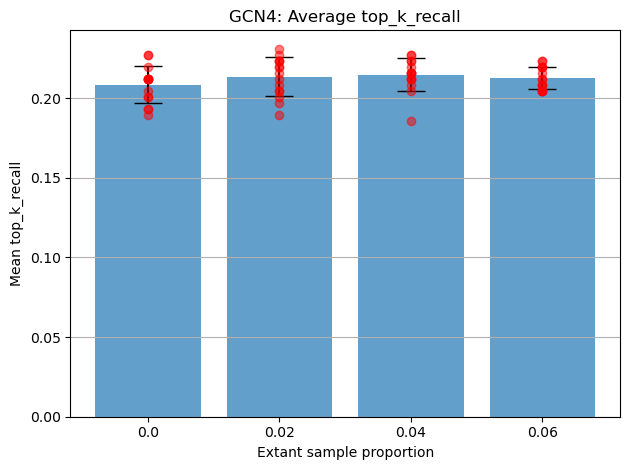

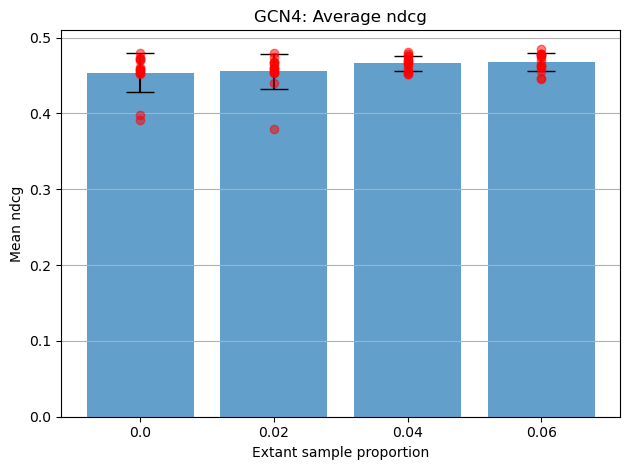

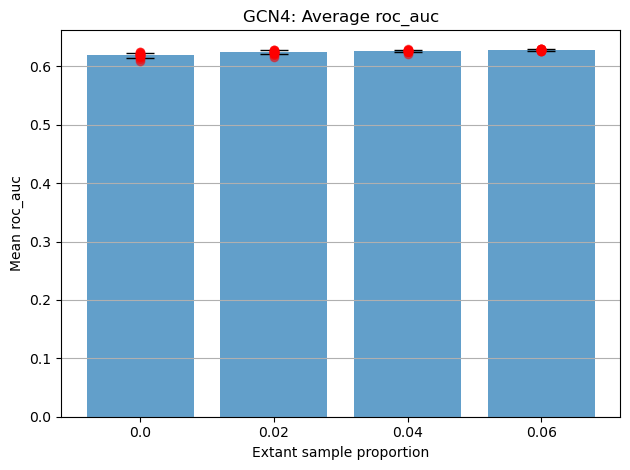

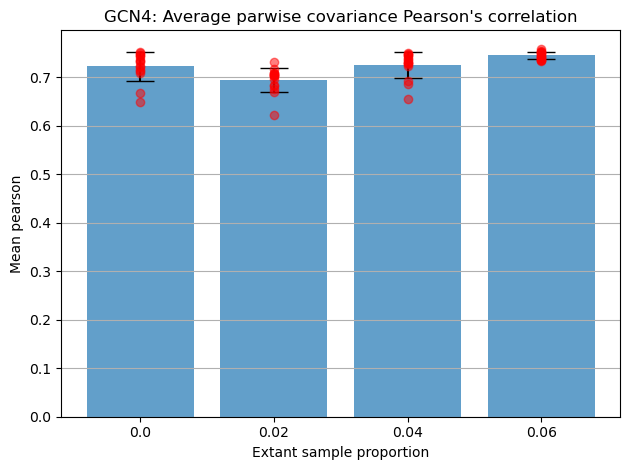

In [63]:
plot_clustering_metrics(gcn4_all_cluster_results, "GCN4")

#### GCN4 Standard results - loss

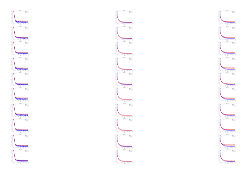

In [55]:
gcn4_std_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gcn4_standard/"
plot_standard_loss(gcn4_std_file_path, "gcn4_std_loss.png", columns=3, rows=10)

#### GCN4 Standard results - metrics: 15 replicates

In [56]:
gcn4_all_std_results = combine_standard_replicates(gcn4_std_file_path, max_reps=10)
gcn4_all_std_results.head()

(30, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gcn4_e_r1/,0.253516,0.231061,0.431857,0.632543,0.014514
1,./gcn4_a_r1/,0.234026,0.208333,0.463126,0.627064,0.836800
2,./gcn4_ae_r1/,0.240747,0.193182,0.478914,0.630876,0.811255
3,./gcn4_e_r2/,0.250479,0.231061,0.454369,0.632319,0.111296
4,./gcn4_a_r2/,0.227295,0.208333,0.472036,0.623613,0.828438


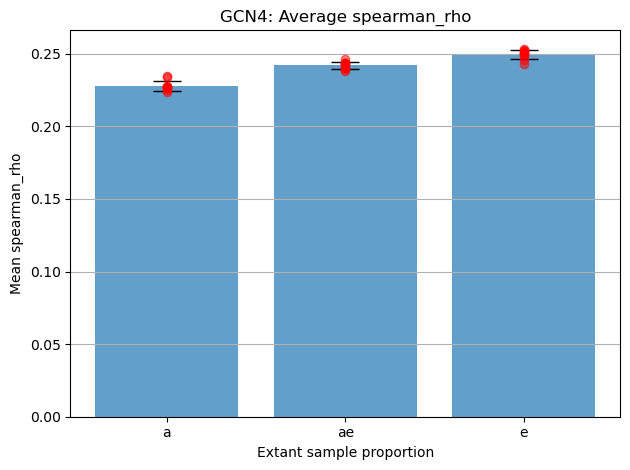

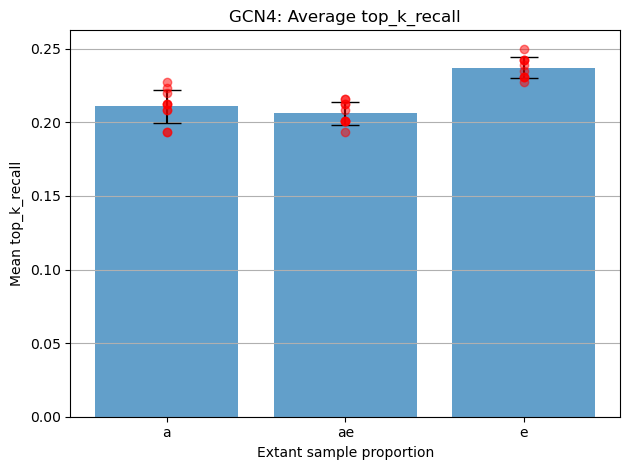

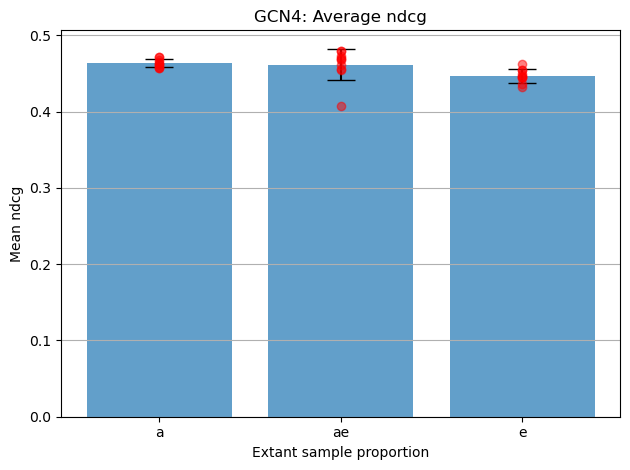

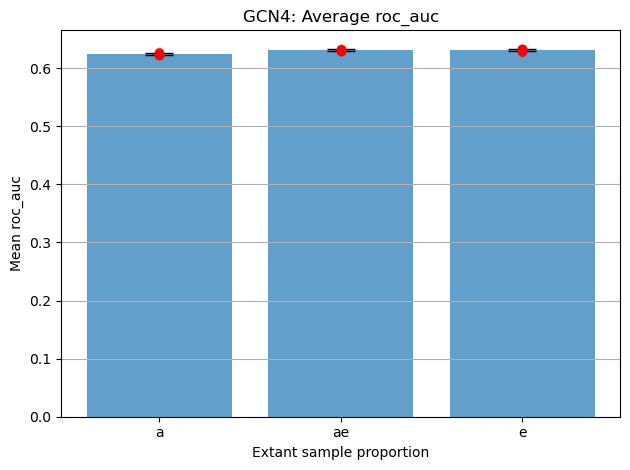

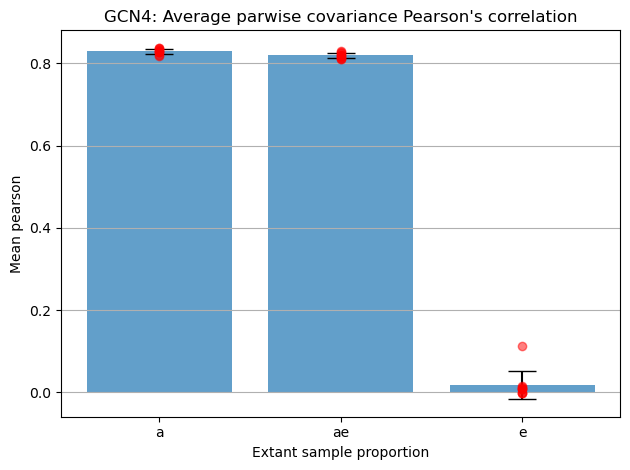

In [57]:
plot_standard_metrics(gcn4_all_std_results, "GCN4")

# GFP

#### Clustering

In [25]:

aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/gfp_ancestors_extants_no_syn_no_dupes.pkl")

In [6]:
aln.head()
st.write_fasta_file("/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/alns/gfp_ancestors_extants_no_syn_no_dupes.fasta", aln)

In [11]:
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gfp/independent_runs/no_synthetic/mmseqs_clustering/gfp_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
# subsets of the dataframes based on the cluster it belongs too 
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape

(1,)

In [17]:
ancs = results[results["is_ancestor"] == 1]
extants = results[results["is_ancestor"] == 0]
ancs.shape, extants.shape

((349, 3), (324, 3))

In [24]:
aln[aln["id"] == "N288_tree_12"]

,id,sequence


In [27]:
SAMPLE_SIZE = 349
extant_proportions = [0.0, 0.05, 0.1, 0.15, 0.2]

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)

        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)

        test[f"rep_{r}"] = indices

    test.to_csv(f"gfp_{p}_replicates.csv", index=False)

In [38]:
test = pd.read_csv("gfp_0.15_replicates.csv")["rep_11"]
thing = aln.loc[test]

In [39]:
thing[thing["id"].str.contains("tree")]

,id,sequence,encoding,weights
360,N0_tree_1,MSSGALLFREKIPYVVEMEGDVNGMKFSVRGKGHGDATTGKIEAKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.033333
361,N1_tree_1,MSAGALLFKQKIPYVVELEGDVNGMKFSVRGKGTGDATTGKIEAKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.028571
363,N3_tree_1,-SAGALLLKQKVPFIMELDAEVNGIRFAVRGKGTGDATTGTIEAKF...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.055556
364,N4_tree_1,-SAGALLLNQKVPFIMELDAEVNGIRFAVRGKGTGDATTGTIDTKF...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.062500
368,N8_tree_1,-SAGALLLNQRVPFIMELDAEVNGIRFAVRGKGTGDATTGIIDTKF...,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066667
...,...,...,...,...
31857,N264_tree_94,MSKGEELFTGVVPILVELDGDVNGHKFSVRGEGEGDATNGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.002110
31986,N34_tree_95,MSKGERLFRGKVPILVELDGDVNGHKFSVRGKGEGDATNGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.002165
32097,N145_tree_95,MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.002101
32149,N197_tree_95,VSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.002045


##### GFP - standard

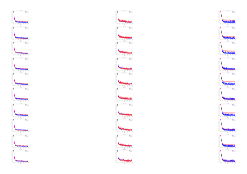

In [58]:
gfp_std_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/standard_test_results/gfp_standard/"
plot_standard_loss(gfp_std_file_path, "gfp_std_loss.png", columns=3, rows=10)

In [59]:
gfp_all_std_results = combine_standard_replicates(gfp_std_file_path, max_reps=10)
gfp_all_std_results.head()

(30, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gfp_a_r1/,0.621021,0.261214,0.860326,0.871836,0.164021
1,./gfp_ae_r1/,0.636005,0.274362,0.864243,0.878918,0.538808
2,./gfp_e_r1/,0.634976,0.270688,0.848098,0.878089,-0.025657
3,./gfp_a_r2/,0.623791,0.266435,0.869541,0.872675,0.272309
4,./gfp_ae_r2/,0.631431,0.269915,0.860379,0.876890,0.594437


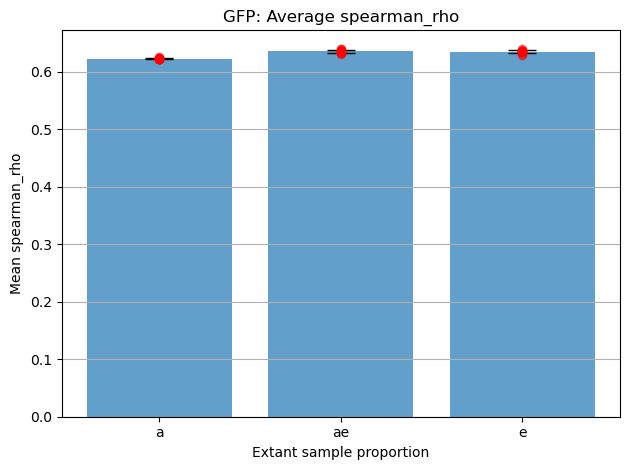

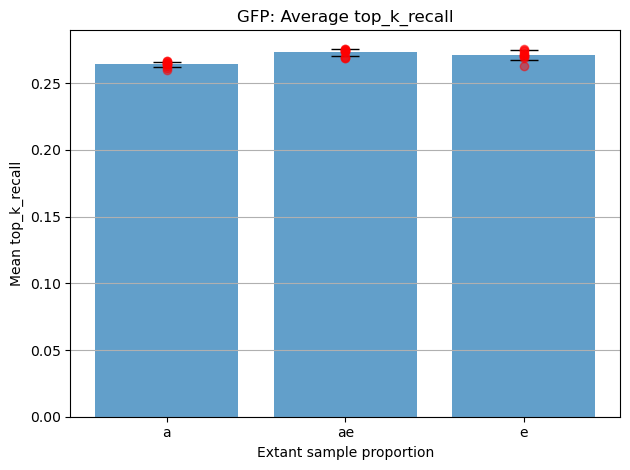

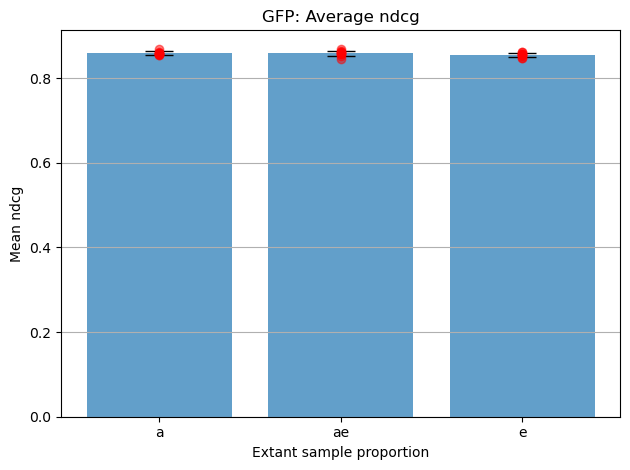

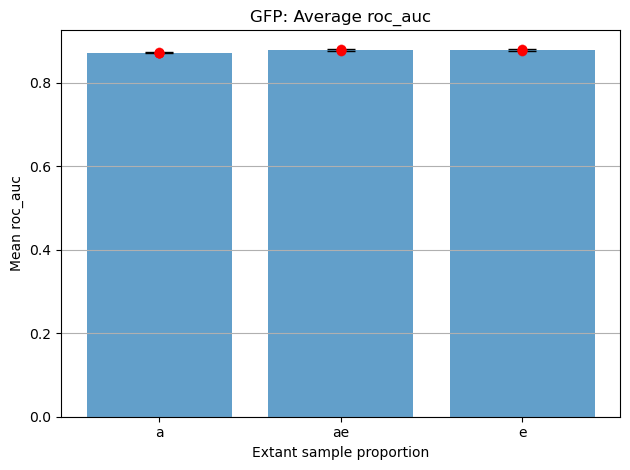

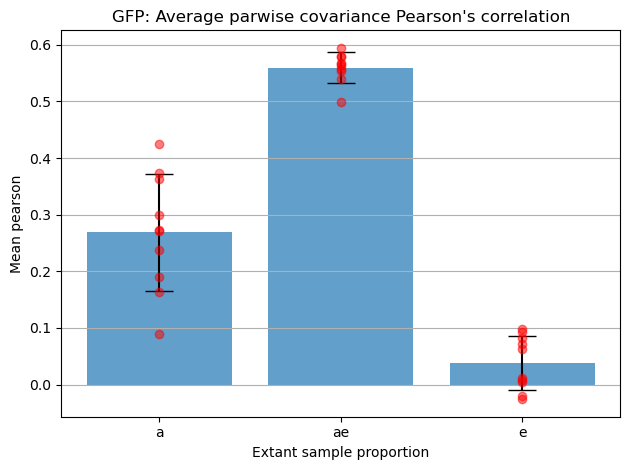

In [60]:
plot_standard_metrics(gfp_all_std_results, "GFP")

#### GFP standard 

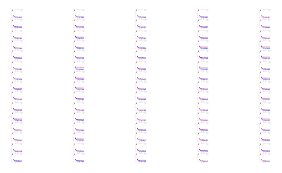

In [65]:
gfp_file_path = "/Users/sebs_mac/uni_OneDrive/honours/data/seb_clustering_results/gfp_seb_clusters/"
figure_name = "gb1_cluster_loss.png"

plot_clustering_loss(gfp_file_path, figure_name, columns=5, rows=15)

In [66]:
gfp_all_cluster_results = combine_clustering_replicates(gfp_file_path, max_reps=15)
gfp_all_cluster_results.head()
gfp_all_cluster_results.head()

(75, 6)


,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,pearson
0,./gfp_0.2_extants_r1/,0.632926,0.267208,0.867823,0.878339,0.076191
1,./gfp_0.15_extants_r1/,0.625356,0.262374,0.867232,0.873286,-0.009779
2,./gfp_0.1_extants_r1/,0.630765,0.265468,0.865650,0.876684,-0.007838
3,./gfp_0.0_extants_r1/,0.628664,0.267981,0.871733,0.874783,-0.012641
4,./gfp_0.05_extants_r1/,0.626134,0.262761,0.865603,0.874325,-0.012641


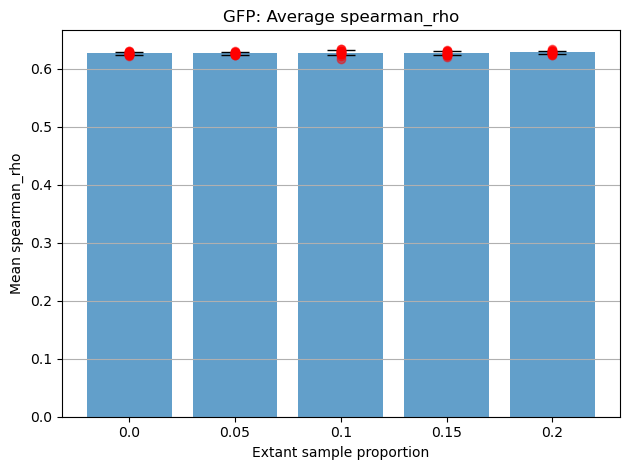

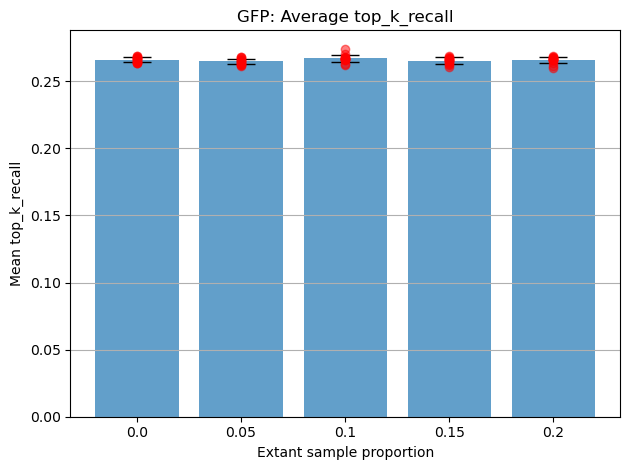

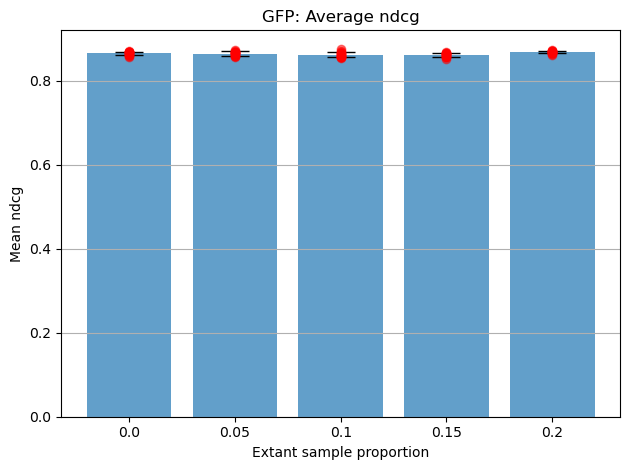

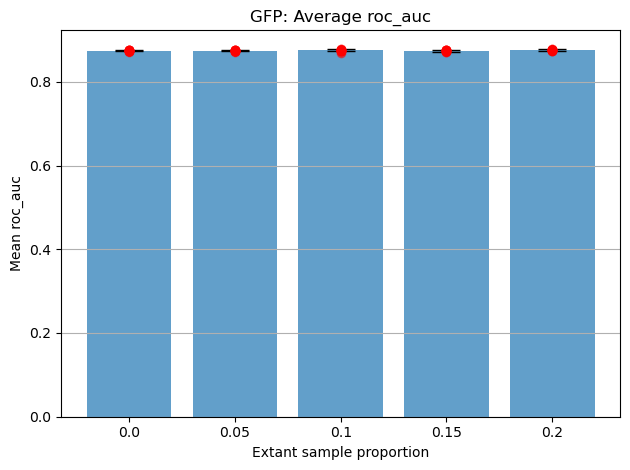

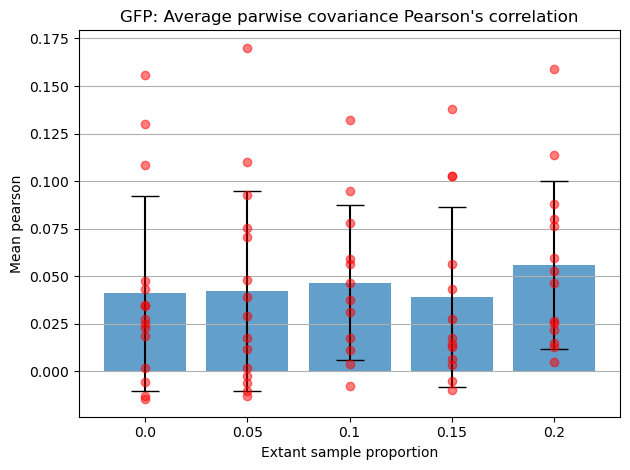

In [67]:
plot_clustering_metrics(gfp_all_cluster_results, "GFP")